# 변동성 돌파전략 구현 시, k 값에 따른 수익률, MDD 값 변화 관찰

## 라이브러리 로드

In [1]:
import pyupbit
import numpy as np
import matplotlib.pyplot as plt

## 사용자 지정 변수

In [2]:
crypto_ticker = "BTC"

krw_ticker = "KRW-"+crypto_ticker
df = pyupbit.get_ohlcv(krw_ticker, count=1500)
fee = 0.0005 # commission rate

In [3]:
def get_ror(k=0.5):
    
    df['range'] = (df['high'] - df['low']) * k
    df['target'] = df['open'] + df['range'].shift(1)

    
    df['ror'] = np.where(df['high'] > df['target'],
                         df['close'] / df['target'] - fee,
                         1)

    ror = df['ror'].cumprod()[-2]
    df['hpr'] = df['ror'].cumprod()

    df['dd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100
    # print("MDD(%): ", df['dd'].max())

    return ror, df['dd'].max()

points = 100
ror = []
dd = []
k_lst = []

for k in range(points+1):
    ror_, dd_ = get_ror(k/points)
    k_lst.append(k/points)
    ror.append(ror_)
    dd.append(dd_)
    #print("%.2f %f %.2f" % (k/100, ror, dd))

## 데이터 확인

In [4]:
print('data points:', len(df))
df

data points: 1475


,open,high,low,close,volume,value,range,target,ror,hpr,dd
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,158000.0,NaN,1.000000,1.000000,0.000000
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,107000.0,4475000.0,1.000000,1.000000,0.000000
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,359000.0,4429000.0,1.050979,1.050979,0.000000
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,253000.0,5016000.0,1.000000,1.050979,0.000000
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,233000.0,4839000.0,1.000000,1.050979,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04 09:00:00,58466000.0,60331000.0,57346000.0,60020000.0,6699.988769,3.923047e+11,2985000.0,60606000.0,1.000000,5.880121,1.949235
2021-10-05 09:00:00,60020000.0,62500000.0,59547000.0,61666000.0,9846.156364,5.962485e+11,2953000.0,63005000.0,1.000000,5.880121,1.949235
2021-10-06 09:00:00,61666000.0,67636000.0,61113000.0,67000000.0,13462.737688,8.645847e+11,6523000.0,64619000.0,1.036347,6.093844,0.000000
2021-10-07 09:00:00,66998000.0,67290000.0,65265000.0,65500000.0,8828.334535,5.841918e+11,2025000.0,73521000.0,1.000000,6.093844,0.000000


설정한 1500 보다는 데이터가 적으며, 2017년 9월 25일의 값부터 포함하고 있다.

## 백테스트 결과 시각화

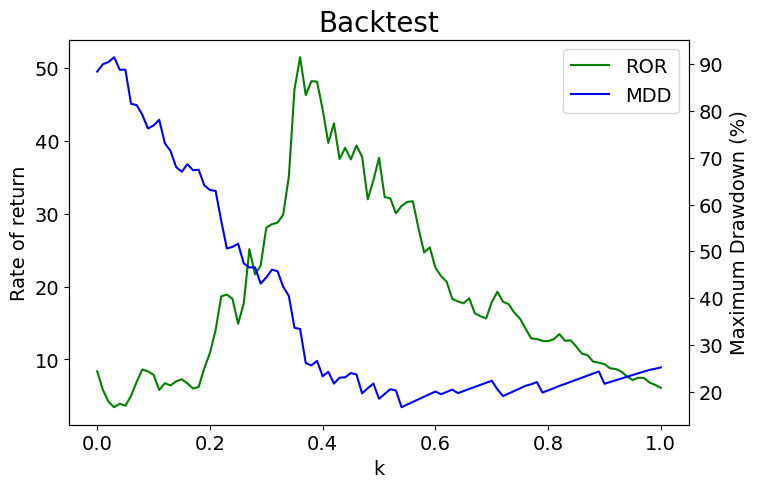

In [5]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 14

fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('Rate of return')
line1 = ax1.plot(k_lst, ror, color='green', label='ROR')


ax2 = ax1.twinx()
ax2.set_ylabel('Maximum Drawdown (%)')
line2 = ax2.plot(k_lst, dd, color='blue', label='MDD')


lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Backtest', fontsize = 20)

plt.show()

개인의 투자성향에 따라 MDD와 수익률이 최적이 되는 최적의 k 값을 지정할 수 있을 것이다.  
최적의 k 를 수익률을 최대로 보였을 때로 가정하고 국내 거래소에서 제공하는 최초 날짜부터 백테스트해본다.  
이 때, 최초 한번 매수하고 어떤 대응도 하지 않은 Buy and hold 전략과 비교했다.

In [6]:
idx = np.argmax(ror)
get_ror(k_lst[idx])

df['buy_n_hold'] = (df['close']-df['close'][0])/df['close'][0]
day = [i.strftime('%Y-%m-%d') for i in df.index ]

In [7]:
df

,open,high,low,close,volume,value,range,target,ror,hpr,dd,buy_n_hold
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,56880.0,NaN,1.000000,1.000000,0.000000,0.000000
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,38520.0,4373880.0,0.987410,0.987410,1.258995,-0.000231
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,129240.0,4360520.0,1.067492,1.054052,0.000000,0.077510
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,91080.0,4786240.0,1.000000,1.054052,0.000000,0.061083
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,83880.0,4677080.0,0.995207,1.049000,0.479328,0.077510
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04 09:00:00,58466000.0,60331000.0,57346000.0,60020000.0,6699.988769,3.923047e+11,1074600.0,59236400.0,1.012728,47.817795,0.000000,12.887089
2021-10-05 09:00:00,60020000.0,62500000.0,59547000.0,61666000.0,9846.156364,5.962485e+11,1063080.0,61094600.0,1.008853,48.241112,0.000000,13.267932
2021-10-06 09:00:00,61666000.0,67636000.0,61113000.0,67000000.0,13462.737688,8.645847e+11,2348280.0,62729080.0,1.067585,51.501496,0.000000,14.502082
2021-10-07 09:00:00,66998000.0,67290000.0,65265000.0,65500000.0,8828.334535,5.841918e+11,729000.0,69346280.0,1.000000,51.501496,0.000000,14.155021


Text(0.5, 1.0, 'Comparison of Strategies (k=0.36), BTC')

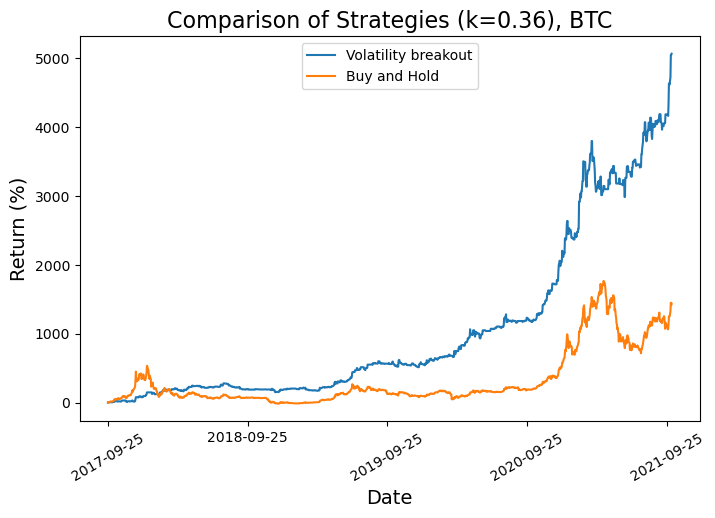

In [8]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter

title = 'Comparison of Strategies (k='+str(k_lst[idx])+"), "+str(crypto_ticker)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 10

fig, ax1 = plt.subplots()
ax1.set_xlabel('Date', fontsize = 14)

ax1.set_ylabel('Return (%)', fontsize = 14)

#x = pd.date_range(day[0], day[-1])
#plt.plot(x, np.arange(len(x)))

ax1=plt.gca()
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_locator(MonthLocator(1))
plt.xticks(rotation=30)

line1 = plt.plot(day, (df['hpr']-1)*100, label='Volatility breakout')
line2 = plt.plot(day, df['buy_n_hold']*100, label='Buy and Hold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center')
plt.title(title, fontsize = 16)

변동성 돌파전략을 통해 MDD를 최대한 줄이면서 수익률을 높일 수 있는 가능성이 확인되었다.  
이 전략은 하락시점에서 손실을 적게 하는 이점이 있지만 상승장에서는 그 상승세를 모두 반영할 수 없는 한계가 있다.  
시장 상황에 맞는 k 값 설정이 필요할 것으로 보인다.  